In [1]:
import pandas as pd
import pandas.io.sql as sqlio
import psycopg2 as ps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import plotly.graph_objs as go
from prophet import Prophet
from matplotlib.lines import Line2D
from matplotlib.dates import YearLocator, DateFormatter
from prophet.plot import plot_plotly
from prophet.plot import plot_components_plotly
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.serialize import model_to_json
from datetime import datetime
from datetime import timedelta


In [2]:
conn = ps.connect(dbname = 'tech', user = 'postgres', password = '1234', host = 'localhost', port = '5432')

In [3]:
sql = """SELECT * FROM dados.dados_brent"""

In [4]:
df = sqlio.read_sql_query(sql,conn)

C:\Users\gabri\AppData\Local\Temp\ipykernel_19000\4192227606.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = sqlio.read_sql_query(sql,conn)


In [5]:
# VISUALIZANDO AS 10 PRIMEIRAS LINHAS #

df.head(10)

data  preco_brent
0  1987-05-20        18.63
1  1987-05-21        18.45
2  1987-05-22        18.55
3  1987-05-25        18.60
4  1987-05-26        18.63
5  1987-05-27        18.60
6  1987-05-28        18.60
7  1987-05-29        18.58
8  1987-06-01        18.65
9  1987-06-02        18.68

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11194 entries, 0 to 11193
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   data         11194 non-null  object 
 1   preco_brent  11194 non-null  float64
dtypes: float64(1), object(1)
memory usage: 175.0+ KB


In [7]:
# Transformando o formato "data"

df['data']= pd.to_datetime(df['data'])

In [8]:
# VISUALIZANDO INFORMAÇÕES #

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11194 entries, 0 to 11193
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         11194 non-null  datetime64[ns]
 1   preco_brent  11194 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 175.0 KB


In [9]:
# Procurando linhas vazias #

df.isnull().sum()

data           0
preco_brent    0
dtype: int64

In [10]:
df_dados = df[['data','preco_brent']]

In [11]:
df_dados['ano'] = df['data'].dt.year
df_dados['mes'] = df['data'].dt.month
df_dados['dia'] = df['data'].dt.day

In [12]:
df_dados.head(10)

data  preco_brent   ano  mes  dia
0 1987-05-20        18.63  1987    5   20
1 1987-05-21        18.45  1987    5   21
2 1987-05-22        18.55  1987    5   22
3 1987-05-25        18.60  1987    5   25
4 1987-05-26        18.63  1987    5   26
5 1987-05-27        18.60  1987    5   27
6 1987-05-28        18.60  1987    5   28
7 1987-05-29        18.58  1987    5   29
8 1987-06-01        18.65  1987    6    1
9 1987-06-02        18.68  1987    6    2

In [13]:
# Quais os anos analisados ?

print(f'Anos analisados:{df_dados.ano.unique()}')

Anos analisados:[1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017 2018 2019 2020 2021 2022 2023 2024]


In [14]:
# Maiores preços do Petroleo Brent no período total

df_sorted = df_dados.sort_values(by='preco_brent', ascending=False)
df_sorted.head()

data  preco_brent   ano  mes  dia
6041 2008-07-03       143.95  2008    7    3
6045 2008-07-07       143.95  2008    7    7
6053 2008-07-15       143.68  2008    7   15
6056 2008-07-18       142.43  2008    7   18
6040 2008-07-02       141.24  2008    7    2

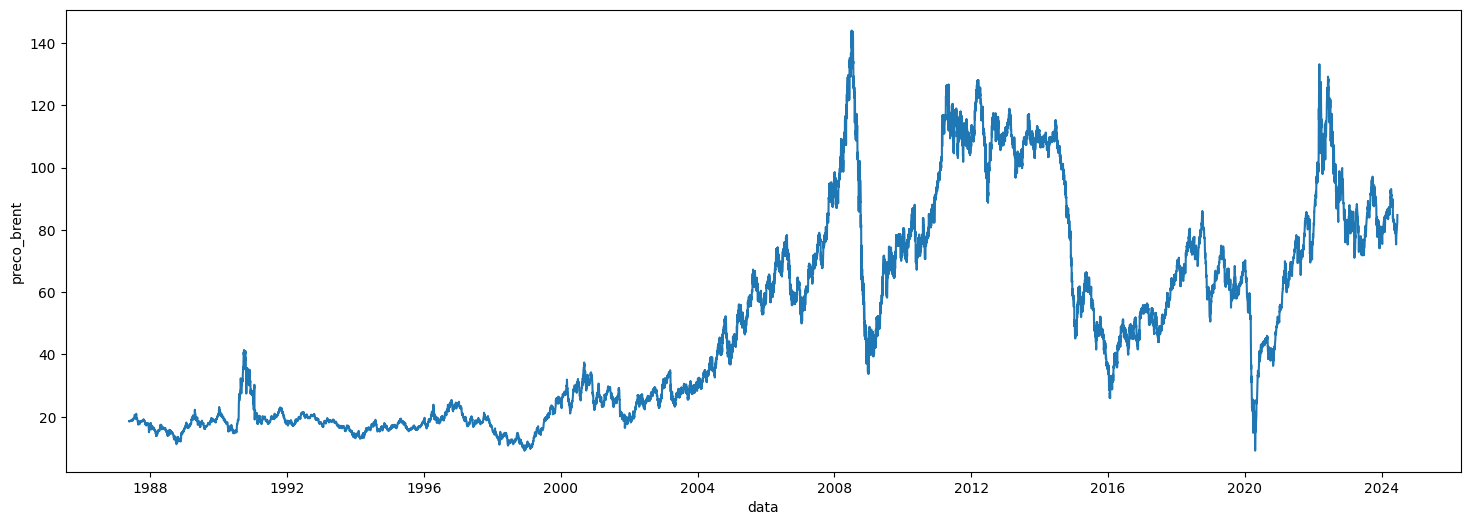

In [15]:
# Gráfico indicando a variação de preço do petróleo Brent durante todo o período

ax = sns.lineplot(data = df_dados, x='data', y='preco_brent',)
ax.figure.set_size_inches(18,6)

In [16]:
print(df)

            data  preco_brent
0     1987-05-20        18.63
1     1987-05-21        18.45
2     1987-05-22        18.55
3     1987-05-25        18.60
4     1987-05-26        18.63
...          ...          ...
11189 2024-06-12        80.52
11190 2024-06-13        81.44
11191 2024-06-14        81.49
11192 2024-06-17        82.45
11193 2024-06-18        84.79

[11194 rows x 2 columns]


In [17]:
df.nunique()

data           11194
preco_brent     5255
dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11194 entries, 0 to 11193
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         11194 non-null  datetime64[ns]
 1   preco_brent  11194 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 175.0 KB


In [19]:
# VALOR MÁXIMO REGISTRADO #

max_value = df_dados['preco_brent'].max()
print(max_value)

143.95


In [20]:
# VALOR MÍNIMO REGISTRADO #

min_value = df_dados['preco_brent'].min()
print(min_value)

9.1


In [21]:
# VALOR MÉDIO #

mean_value = df_dados['preco_brent'].mean()
print(mean_value)

53.08366624977667


In [22]:
# DESVIO PADRÃO #

desvio_padrao = df_dados['preco_brent'].std()
print(desvio_padrao)

33.215700007981184


In [23]:
# MEDIANA #

mediana = df_dados['preco_brent'].median()
print(mediana)

48.345


In [24]:
# PRIMEIRO QUARTIL 25% #

primeiro_quartil = df_dados['preco_brent'].quantile(0.25)
print(primeiro_quartil)

20.5075


In [25]:
# SEGUNDO QUARTIL 50% #

segundo_quartil = df_dados['preco_brent'].quantile(0.50)
print(segundo_quartil)

48.345


In [26]:
# TERCEIRO QUARTIL 75% #

terceiro_quartil = df_dados['preco_brent'].quantile(0.75)
print(terceiro_quartil)

76.57


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11194 entries, 0 to 11193
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   data         11194 non-null  datetime64[ns]
 1   preco_brent  11194 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 175.0 KB


<Axes: xlabel='preco_brent', ylabel='Count'>

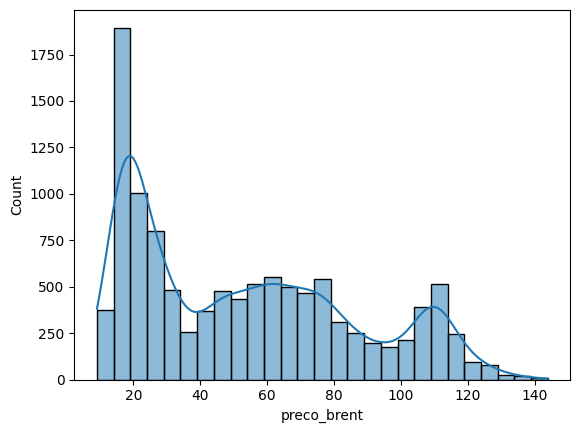

In [28]:
# GERANDO O HISTOGRAMA

sns.histplot(data=df.preco_brent, kde=True)

<Axes: ylabel='preco_brent'>

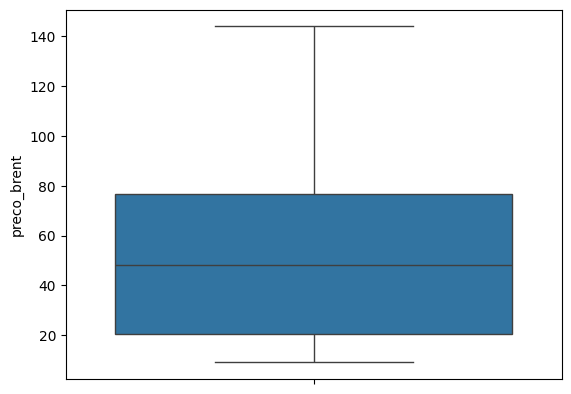

In [29]:
# GERANDO O BOXPLOT

sns.boxplot(data=df.preco_brent)

In [30]:
# CRIANDO MODELO ML

def plot_eventos(ponto: pd.Series, id_evento: int):
  if not ponto.empty:
    plt.scatter(ponto.date, float(ponto.preco_brent), s=200, facecolors='none', edgecolors='red', linewidths=2)
    plt.text(ponto.date, float(ponto.preco_brent) + 4, id_evento, ha='center', va='center', fontsize=8, fontweight='bold', color='red', bbox=dict(facecolor='white', alpha=0.4, edgecolor='red', boxstyle='round', lw=2))


C:\Users\gabri\AppData\Local\Temp\ipykernel_19000\1357259210.py:47: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  plot_eventos(df.query('data == "1990-08-02"'), 1)
C:\Users\gabri\AppData\Local\Temp\ipykernel_19000\1357259210.py:48: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  plot_eventos(df.query('data == "2001-09-11"'), 2)
C:\Users\gabri\AppData\Local\Temp\ipykernel_19000\1357259210.py:49: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explic

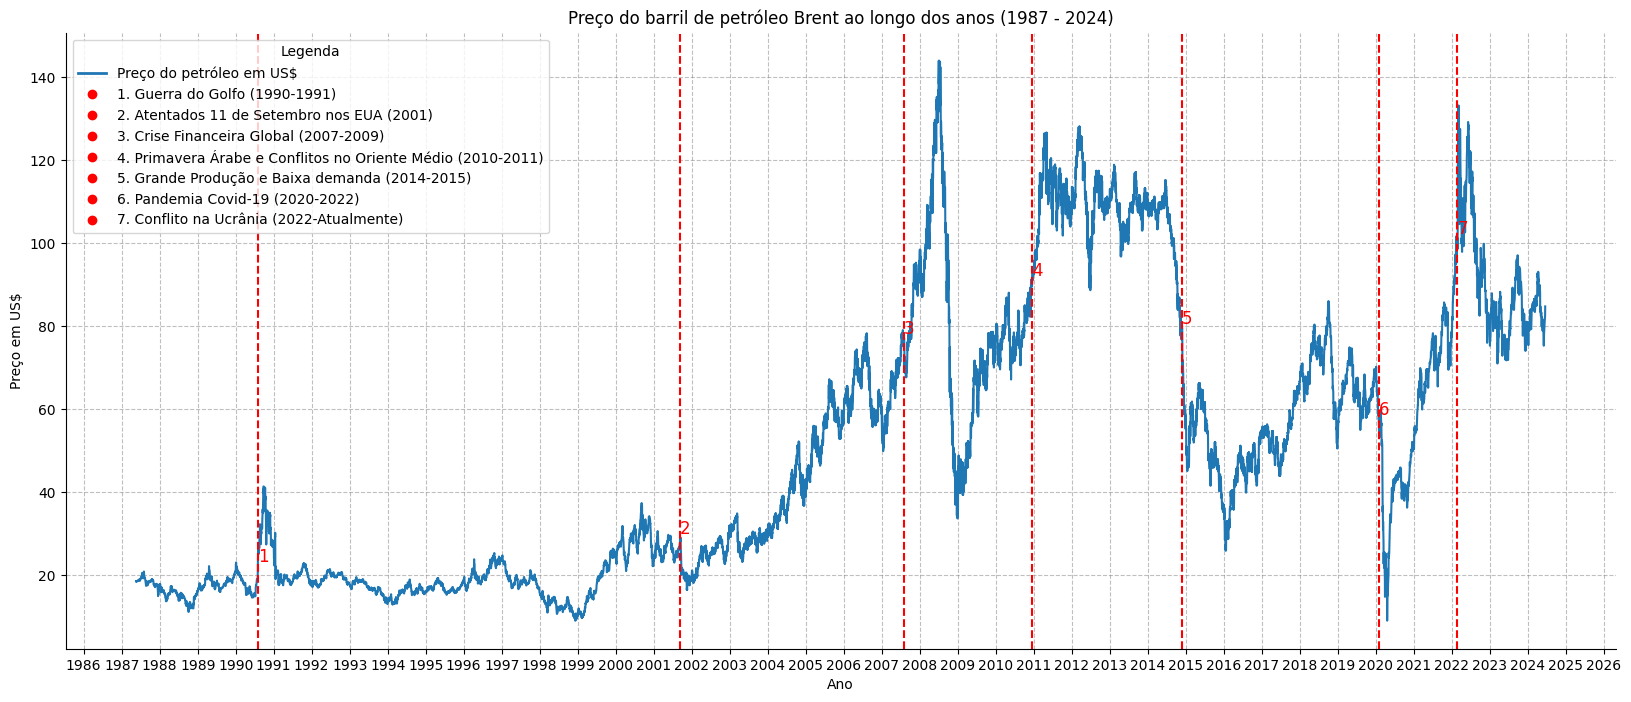

In [31]:
# CRIANDO MODELO ML

def plot_eventos(ponto: pd.Series, id_evento: int):
  if not ponto.empty:
    plt.scatter(ponto.date, float(ponto.preco_brent), s=200, facecolors='none', edgecolors='red', linewidths=2)
    plt.text(ponto.date, float(ponto.preco_brent) + 4, id_evento, ha='center', va='center', fontsize=8, fontweight='bold', color='red', bbox=dict(facecolor='white', alpha=0.4, edgecolor='red', boxstyle='round', lw=2))

# Função para configurar a legenda

def set_legenda():
    legend_handles, _ = plt.gca().get_legend_handles_labels()
    extra_labels = [
        ('Preço do petróleo em US$', '#1F77B4', 'line'),
        ('1. Guerra do Golfo (1990-1991)', 'red', 'dot'),
        ('2. Atentados 11 de Setembro nos EUA (2001)', 'red', 'dot'),
        ('3. Crise Financeira Global (2007-2009)', 'red', 'dot'),
        ('4. Primavera Árabe e Conflitos no Oriente Médio (2010-2011)', 'red', 'dot'),
        ('5. Grande Produção e Baixa demanda (2014-2015)', 'red', 'dot'),
        ('6. Pandemia Covid-19 (2020-2022)', 'red', 'dot'),
        ('7. Conflito na Ucrânia (2022-Atualmente)', 'red', 'dot')
    ]

    for label, color, linestyle in extra_labels:
        if linestyle == 'line':
            legend_handles.append(Line2D([0], [0], color=color, lw=2, label=label))
        elif linestyle == 'dot':
            legend_handles.append(Line2D([0], [0], color=color, marker='o', linestyle='', label=label))

    plt.legend(title='Legenda', loc='upper left', handles=legend_handles)

# Função para plotar eventos importantes
def plot_eventos(df_evento, evento_id):
    for _, row in df_evento.iterrows():
        plt.axvline(x=row['data'], color='red', linestyle='--')
        plt.text(row['data'], row['preco_brent'], str(evento_id), color='red', fontsize=12, verticalalignment='bottom')


# Configurarando o gráfico
plt.figure(figsize=(20, 8))
ax = sns.lineplot(data=df, x='data', y='preco_brent', legend=False)
ax.set_ylabel('Preço em US$')
ax.set_xlabel('Ano')
plt.gca().xaxis.set_major_locator(YearLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%Y'))

# Plotar os eventos importantes
plot_eventos(df.query('data == "1990-08-02"'), 1)
plot_eventos(df.query('data == "2001-09-11"'), 2)
plot_eventos(df.query('data == "2007-08-01"'), 3)
plot_eventos(df.query('data == "2010-12-20"'), 4)
plot_eventos(df.query('data == "2014-11-28"'), 5)
plot_eventos(df.query('data == "2020-01-30"'), 6)
plot_eventos(df.query('data == "2022-02-24"'), 7)

# Configurações finais do gráfico
plt.grid(linestyle='--', color='gray', alpha=0.5)
sns.despine()
set_legenda()
plt.title('Preço do barril de petróleo Brent ao longo dos anos (1987 - 2024)')
plt.show()


In [32]:
# Preparando para executar ML

def dados_ml() -> pd.DataFrame:
  return df.query('data >= "2015-01-01"')

In [33]:

df_ml = dados_ml()
df_ml = df[['data', 'preco_brent']]
df_ml.columns = ['ds', 'y']
df_ml.head()

ds      y
0 1987-05-20  18.63
1 1987-05-21  18.45
2 1987-05-22  18.55
3 1987-05-25  18.60
4 1987-05-26  18.63

In [34]:
# https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning
def parametros_prophet(train_data: pd.DataFrame):
  param_grid = {
      'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
      'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
  }

  # todas combinações de parâmetros configuradas
  all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
  rmses = []

  # cross_validation para avaliar todos os parâmetros
  for params in all_params:
      m = Prophet(**params).fit(train_data)
      df_cv = cross_validation(m, horizon='30 days', parallel="processes")
      df_p = performance_metrics(df_cv, rolling_window=1)
      rmses.append(df_p['rmse'].values[0])

  # procurando os melhores hiperparâmetros
  tuning_results = pd.DataFrame(all_params)
  tuning_results['rmse'] = rmses
  print(tuning_results)

  # melhores parâmetros
  best_params = all_params[np.argmin(rmses)]
  print(best_params)

In [35]:
#parametros_prophet(df_ml)

In [36]:
# cria o modelo do prophet com os melhores hiperparâmetros
modelo = Prophet(seasonality_mode='additive', daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True, changepoint_prior_scale=0.5, seasonality_prior_scale=10.0)
modelo.add_country_holidays(country_name='BR')
modelo.fit(df_ml)

18:25:37 - cmdstanpy - INFO - Chain [1] start processing
18:25:53 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# faz a previsão dos próximos 30 dias para o preço do barril de petróleo do tipo Brent

df_futuro = modelo.make_future_dataframe(periods=30, freq='D')
previsao = modelo.predict(df_futuro)
previsao.tail(45)

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
11179 2024-05-29  89.883743   78.013560  104.399661    89.883743    89.883743   
11180 2024-05-30  89.898390   79.271844  103.007832    89.898390    89.898390   
11181 2024-05-31  89.913036   77.931182  103.651109    89.913036    89.913036   
11182 2024-06-03  89.956977   78.628852  103.744742    89.956977    89.956977   
11183 2024-06-04  89.971623   77.961897  102.799827    89.971623    89.971623   
11184 2024-06-05  89.986270   78.168968  103.236658    89.986270    89.986270   
11185 2024-06-06  90.000917   78.037849  103.726063    90.000917    90.000917   
11186 2024-06-07  90.015564   78.485052  102.924063    90.015564    90.015564   
11187 2024-06-10  90.059504   78.652826  103.846553    90.059504    90.059504   
11188 2024-06-11  90.074150   77.388336  103.555123    90.074150    90.074150   
11189 2024-06-12  90.088797   78.809195  104.055861    90.088797    90.088797   
11190 2024-06-13  90.103444   78.289607  103.636165    90.103444    90.103444   
11191 2024-06-14  90.118091   78.483899  103.381949    90.118091    90.118091   
11192 2024-06-17  90.162031   79.127886  104.167270    90.162031    90.162031   
11193 2024-06-18  90.176678   79.173352  103.770552    90.176678    90.176678   
11194 2024-06-19  90.191324   78.402070  103.924536    90.191324    90.191324   
11195 2024-06-20  90.205971   76.755511  104.312134    90.205971    90.205971   
11196 2024-06-21  90.220618   77.983023  104.682604    90.220618    90.220618   
11197 2024-06-22  90.235265   79.115692  104.584389    90.235265    90.235265   
11198 2024-06-23  90.249911   79.381509  104.354577    90.249911    90.249911   
11199 2024-06-24  90.264558   78.221617  104.159127    90.264558    90.264558   
11200 2024-06-25  90.279205   78.264498  103.872660    90.279205    90.279205   
11201 2024-06-26  90.293851   78.767272  104.244719    90.293851    90.293851   
11202 2024-06-27  90.308498   78.280293  104.629796    90.308498    90.308498   
11203 2024-06-28  90.323145   79.266348  104.832547    90.323145    90.323145   
11204 2024-06-29  90.337792   79.479921  104.983352    90.337792    90.337792   
11205 2024-06-30  90.352438   79.244225  104.582172    90.352438    90.352438   
11206 2024-07-01  90.367085   79.031540  104.000988    90.367085    90.367085   
11207 2024-07-02  90.381732   79.775528  105.347974    90.381732    90.381732   
11208 2024-07-03  90.396379   79.410898  104.621625    90.396379    90.396379   
11209 2024-07-04  90.411025   79.276156  105.579299    90.411025    90.411025   
11210 2024-07-05  90.425672   79.945315  105.338630    90.425672    90.425672   
11211 2024-07-06  90.440319   80.806186  105.742749    90.440319    90.440319   
11212 2024-07-07  90.454966   79.129887  104.309358    90.454966    90.454966   
11213 2024-07-08  90.469612   79.810624  105.305979    90.469612    90.469612   
11214 2024-07-09  90.484259   79.499528  104.502626    90.484259    90.484259   
11215 2024-07-10  90.498906   78.872833  106.038190    90.498906    90.498906   
11216 2024-07-11  90.513553   79.329159  104.591517    90.513553    90.513553   
11217 2024-07-12  90.528199   79.697147  105.143217    90.528199    90.528199   
11218 2024-07-13  90.542846   79.888101  105.626874    90.542846    90.542846   
11219 2024-07-14  90.557493   80.816143  105.424052    90.557493    90.557493   
11220 2024-07-15  90.572139   80.323931  104.921508    90.572139    90.572139   
11221 2024-07-16  90.586786   79.901430  104.863178    90.586786    90.586786   
11222 2024-07-17  90.601433   80.400810  105.740117    90.601433    90.601433   
11223 2024-07-18  90.616080   79.933208  106.690862    90.616080    90.616080   

       Ano novo  Ano novo_lower  Ano novo_upper  Carnaval  ...    weekly  \
11179       0.0             0.0             0.0       0.0  ... -0.159143   
11180       0.0             0.0             0.0       0.0  ... -0.051337   
11181       0.0             0.0             0.0       0.0  

In [38]:
# plot dos preços históricos (desde 2020) + janela de previsão
fig = plot_plotly(modelo, previsao, trend=True, figsize=(1200, 900))

# para checar as configs criadas pelo Plotly
# print(fig)

linha_azul = go.Scatter(x=[2020, previsao.iloc[-1, :].ds], y=[0, 0], mode='lines', line=dict(color='blue'), name='US$ 0,00')
linha_amarela = go.Scatter(x=[2020, previsao.iloc[-1, :].ds], y=[50, 50], mode='lines', line=dict(color='gold'), name='US$ 50,00')
linha_vermelha = go.Scatter(x=[2020, previsao.iloc[-1,:].ds], y=[100, 100], mode='lines', line=dict(color='red'), name='US$ 100,00')
fig.update_layout(title='Distribuição do valor (US$) do barril de petróleo Brent entre 2020 e os dias atuais + previsão dos próximos 30 dias', showlegend=True)
fig.data[0].name = 'Realidade'
fig.data[1].name = 'Banda inferior da previsão'
fig.data[1].fill = 'tonexty'
fig.data[1].fillcolor = 'rgba(0, 114, 178, 0.2)'
fig.data[2].name = 'Previsão'
fig.data[3].name = 'Banda superior da previsão'
fig.data[4].name = 'Tendência'
fig.add_trace(linha_azul)
fig.add_trace(linha_amarela)
fig.add_trace(linha_vermelha)
fig.show()

In [39]:
plot_components_plotly(modelo, previsao)

In [40]:
print(fig)

Figure({
    'data': [{'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Realidade',
              'type': 'scatter',
              'x': array([datetime.datetime(1987, 5, 20, 0, 0),
                          datetime.datetime(1987, 5, 21, 0, 0),
                          datetime.datetime(1987, 5, 22, 0, 0), ...,
                          datetime.datetime(2024, 6, 14, 0, 0),
                          datetime.datetime(2024, 6, 17, 0, 0),
                          datetime.datetime(2024, 6, 18, 0, 0)], dtype=object),
              'y': array([18.63, 18.45, 18.55, ..., 81.49, 82.45, 84.79])},
             {'fill': 'tonexty',
              'fillcolor': 'rgba(0, 114, 178, 0.2)',
              'hoverinfo': 'skip',
              'line': {'width': 0},
              'mode': 'lines',
              'name': 'Banda inferior da previsão',
              'type': 'scatter',
              'x': array([datetime.datetime(1987, 5, 20, 0, 0),
                 

In [41]:
def calcular_mape_previsao(previsao: pd.DataFrame, train_data: pd.DataFrame):
  # extrai as colunas relevantes dos dataframes
  previsao_cols = ['ds', 'yhat']
  valores_reais_cols = ['ds', 'y']

  previsao = previsao[previsao_cols]
  valores_reais = train_data[valores_reais_cols]

  # merge os dataframes nas colunas 'ds' para comparar previsões e valores reais
  resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

  # calcula o erro percentual absoluto para cada ponto de dados
  resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

  # cálculo do MAPE
  mape = np.mean(resultados['erro_percentual_absoluto'])
  mape_decimal = np.round(mape / 100, 2)

  print(f'MAPE decimal: {mape_decimal:.2f}')
  print(f"MAPE: {mape:.8f}%")

In [42]:
calcular_mape_previsao(previsao, df_ml)


MAPE decimal: 0.13
MAPE: 13.19488537%


In [43]:
df_cv = cross_validation(modelo, horizon='90 days', parallel="processes")
df_p = performance_metrics(df_cv)
df_p.head(81)

horizon         mse       rmse        mae      mape     mdape     smape  \
0   9 days  271.710310  16.483638  10.961234  0.197261  0.131660  0.192262   
1  10 days  273.873529  16.549125  11.043419  0.199314  0.133750  0.194153   
2  11 days  277.142335  16.647592  11.121635  0.202714  0.135678  0.196102   
3  12 days  281.130891  16.766958  11.225064  0.205254  0.137332  0.198205   
4  13 days  282.565514  16.809685  11.286499  0.207813  0.137120  0.200376   
..     ...         ...        ...        ...       ...       ...       ...   
76 85 days  393.213832  19.829620  13.859209  0.273873  0.202010  0.266219   
77 86 days  394.861800  19.871130  13.921905  0.275613  0.202930  0.268112   
78 87 days  399.046571  19.976150  13.994822  0.277600  0.203909  0.269630   
79 88 days  401.531092  20.038241  14.032704  0.278577  0.205691  0.270754   
80 89 days  402.643405  20.065976  14.069556  0.278987  0.207524  0.271731   

    coverage  
0   0.404453  
1   0.395179  
2   0.391105  
3   0.379504  
4   0.372522  
..       ...  
76  0.353917  
77  0.354619  
78  0.357559  
79  0.360018  
80  0.364430  

[81 rows x 8 columns]

EXPORTANDO O MODELO

In [44]:
df_p.to_csv('prophet-performance.csv', index=False)

In [45]:
with open('prophet-model.json', 'w') as f_out:
    f_out.write(model_to_json(modelo))